In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from datetime import datetime, timedelta
import re

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

plt.rcParams['figure.figsize'] = (10,10)

In [2]:
# функция подсчета границы выбросов
def get_outlier_iqr(df, column):
    perc75 = df[column].quantile(q=0.75, interpolation='midpoint')
    perc25 = df[column].quantile(q=0.25, interpolation='midpoint')
    iqr = perc75-perc25

    cols = df[column].value_counts().index

    # границы выбросов
    upper_bound = perc75+1.5*iqr
    lower_bound = perc25-1.5*iqr

    print('25-й перцентиль: {}, '.format(perc25),
          '75-й перцентиль: {}, '.format(perc75),
          'IQR: {}, '.format(iqr),
          'Границы выбросов: [{f}<->{l}]\n'.format(f=lower_bound, l=upper_bound))

    count = []  # лист выбросов
    for i in cols:
        if i > upper_bound and i > perc75:
            count.append(i)
        elif i < lower_bound and i < perc25:
            count.append(i)
    if len(count) == 0:
        print('Выбросов нет')
    else:
        print('Значения которые являются выбросами: ', sorted(count))

In [3]:
df_train = pd.read_csv('main_task.csv')
df_test = pd.read_csv('kaggle_task.csv')

df_train['sample'] = 1

df_test['sample'] = 0
df_test['Rating'] = 0

data = df_test.append(df_train, sort=False).reset_index(drop=True)

- **City**: Город 
- **Cuisine Style**: Кухня
- **Ranking**: Ранг ресторана относительно других ресторанов в этом городе
- **Price Range**: Цены в ресторане в 3 категориях
- **Number of Reviews**: Количество отзывов
- **Reviews**: 2 последних отзыва и даты этих отзывов
- **URL_TA**: страница ресторана на 'www.tripadvisor.com' 
- **ID_TA**: ID ресторана в TripAdvisor
- **Rating**: Рейтинг ресторана

In [4]:
data.head()

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [6]:
for i in list(data.columns):
    print('Column "{}": {}'.format(i, data[i].nunique()))

Column "Restaurant_id": 13094
Column "City": 31
Column "Cuisine Style": 10731
Column "Ranking": 12975
Column "Price Range": 3
Column "Number of Reviews": 1573
Column "Reviews": 41857
Column "URL_TA": 49963
Column "ID_TA": 49963
Column "sample": 2
Column "Rating": 10


In [7]:
data = data.drop(['ID_TA', 'URL_TA'], axis=1)

# Restaurant_id	

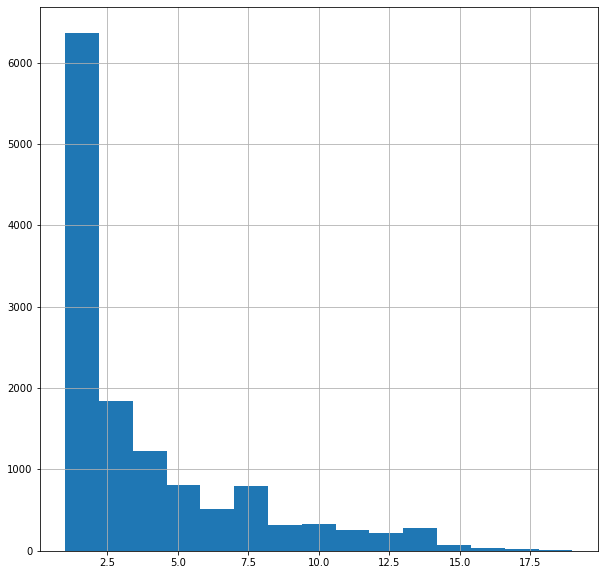

In [8]:
data['Restaurant_id'].value_counts().hist(bins=15)
# plt.tight_layout()

In [9]:
# Есть повторяющиеся id ресторанов. Однако их url различны.
# Из этого сделаем предположение, что под id может подразумеваться сеть ресторанов.
data['chain_size'] = data['Restaurant_id'].map(data['Restaurant_id'].value_counts().to_dict())

# Dummy-переменные: 0 если принадлежит к сети ресторанов, 1 если нет
data['chain'] = data['chain_size'].apply(lambda x: 0 if x > 1 else 1)

# chain_size скоррелировал с ranking
# Создадим из двух один параметр
data['ranking-chain_size'] = data['Ranking'] / data['chain_size']

# data['chain_representation'] = data['Restaurant_id'].map(data.groupby(['Restaurant_id'])['City'].nunique().to_dict())
# chain_count = len(data[data['chain'] == 0]['Restaurant_id'].value_counts())
# data['chain_relative_size'] = data['chain_size'].apply(lambda x: x / chain_count if x > 1 else 0)
# scaler=MinMaxScaler()
# scaler=StandardScaler()
# data['chain_size_norm'] = scaler.fit_transform(pd.DataFrame(data['chain_size']))

# City

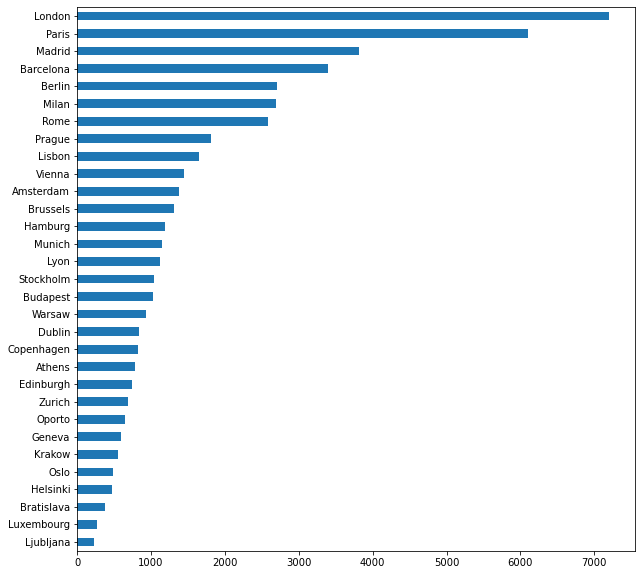

In [10]:
data['City'].value_counts(ascending=True).plot(kind='barh')

In [11]:
# Исправим написание города Oporto => Porto
# https://en.wikipedia.org/wiki/Porto
data['City'] = data['City'].apply(lambda x: 'Porto' if x == 'Oporto' else x)

In [12]:
# Заменим названия стран на Dummy-переменные
data['city_id'] = data['City']
le = LabelEncoder()
le.fit(data['city_id'])
data['city_id'] = le.transform(data['city_id'])

---
#### New data 1

##### Описание датасета
- **city** - The name of the city/town as a Unicode string (e.g. Goiânia).			
- **city_ascii** - city as an ASCII string (e.g. Goiania). Left blank if ASCII representation is not possible.			
- **lat** - The latitude of the city/town.			
- **lng** - The longitude of the city/town.			
- **country** - The name of the city/town's country.			
- **iso2** - The alpha-2 iso code of the country.			
- **iso3** - The alpha-3 iso code of the country.		
- **admin_name** - The name of the highest level administration region of the city town (e.g. a US state or Canadian province). Possibly blank.				
- **capital** - Blank string if not a capital, otherwise:
    - *primary* - country's capital (e.g. Washington D.C.)
    - *admin* - first-level admin capital (e.g. Little Rock, AR)
    - *minor* - lower-level admin capital (e.g. Fayetteville, AR)
- **population** - An estimate of the city's urban population. Only available for some (prominent) cities. If the urban population is not available, the municipal population is used.			
- **id** - A 10-digit unique id generated by SimpleMaps. We make every effort to keep it consistent across releases and databases (e.g. U.S Cities Database).

In [13]:
# Загружаем дополнительные данные
cities = pd.read_csv('worldcities.csv')
cities.head(1)

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,Tokyo,Tokyo,35.6897,139.6922,Japan,JP,JPN,Tōkyō,primary,37977000.0,1392685764


In [14]:
# Удалим столбцы которые не планируются к использованию
cities = cities.drop(['city', 'lat', 'lng', 'iso2', 'iso3', 'admin_name', 'id'], axis=1)
cities.head(1)

,city_ascii,country,capital,population
0,Tokyo,Japan,primary,37977000.0


In [15]:
cities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26569 entries, 0 to 26568
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   city_ascii  26569 non-null  object 
 1   country     26569 non-null  object 
 2   capital     7626 non-null   object 
 3   population  25596 non-null  float64
dtypes: float64(1), object(3)
memory usage: 830.4+ KB


In [16]:
# В датасете имеется множество одноименных городов
cities[cities['city_ascii']=='Paris']

,city_ascii,country,capital,population
33,Paris,France,primary,11020000.0
13940,Paris,United States,NaN,26010.0
18656,Paris,United States,NaN,12485.0
19969,Paris,United States,NaN,10536.0
21764,Paris,United States,NaN,8394.0
25704,Paris,United States,NaN,5131.0


In [17]:
# Оставим только "основные" (структура датасета это позволяет)
cities = cities.drop_duplicates(subset=['city_ascii'], keep='first')

In [18]:
# Добавим новые данные к основному датасету
cities.columns = ['City', 'Country', 'Capital', 'Population']
# cities.columns = [column.capitalize() for column in list(cities.columns)]
data = data.merge(cities, on = 'City', how = 'left')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Restaurant_id       50000 non-null  object 
 1   City                50000 non-null  object 
 2   Cuisine Style       38410 non-null  object 
 3   Ranking             50000 non-null  float64
 4   Price Range         32639 non-null  object 
 5   Number of Reviews   46800 non-null  float64
 6   Reviews             49998 non-null  object 
 7   sample              50000 non-null  int64  
 8   Rating              50000 non-null  float64
 9   chain_size          50000 non-null  int64  
 10  chain               50000 non-null  int64  
 11  ranking-chain_size  50000 non-null  float64
 12  city_id             50000 non-null  int32  
 13  Country             50000 non-null  object 
 14  Capital             49255 non-null  object 
 15  Population          50000 non-null  float64
dtypes: f

---
# Capital (new data)

In [19]:
# (13 Capital 39404 non-null object)
data[data['Capital'].isna()]['City'].value_counts()

Edinburgh    745
Name: City, dtype: int64

In [20]:
# Заполним пропуски
# Edinburgh - столица Шотландии
data['Capital'] = data['Capital'].fillna('primary')

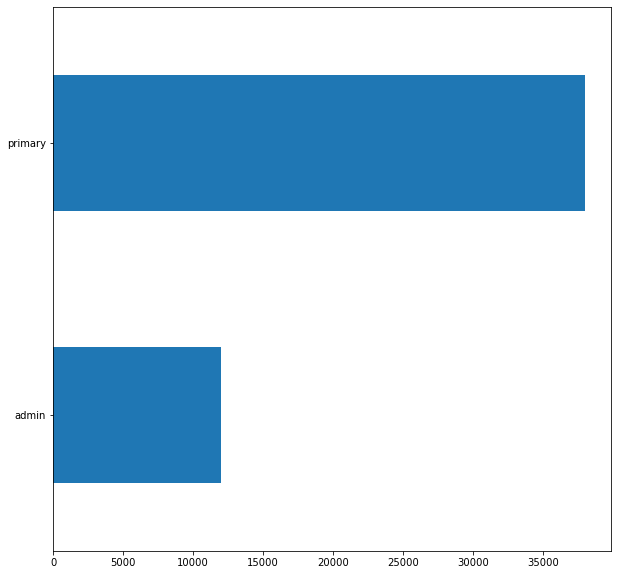

In [21]:
data['Capital'].value_counts(ascending=True).plot(kind='barh')

In [22]:
# Заменим Dummy-переменной: 0 если столица, 1 если нет
data['Capital'] = data['Capital'].apply(lambda x: 0 if x=='primary' else 1)

# Country (new data)

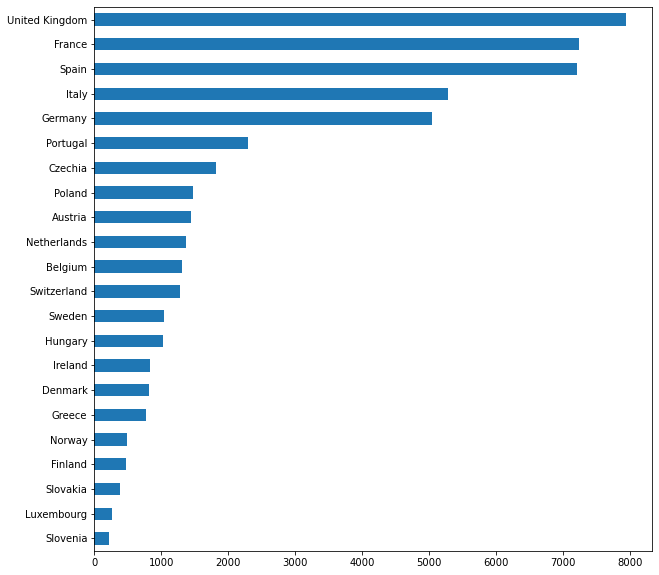

In [23]:
data['Country'].value_counts(ascending=True).plot(kind='barh')

In [24]:
# Заменим названия стран на Dummy-переменные
data['country_id'] = data['Country']
le.fit(data['country_id'])
data['country_id'] = le.transform(data['country_id'])

# Population (new data)

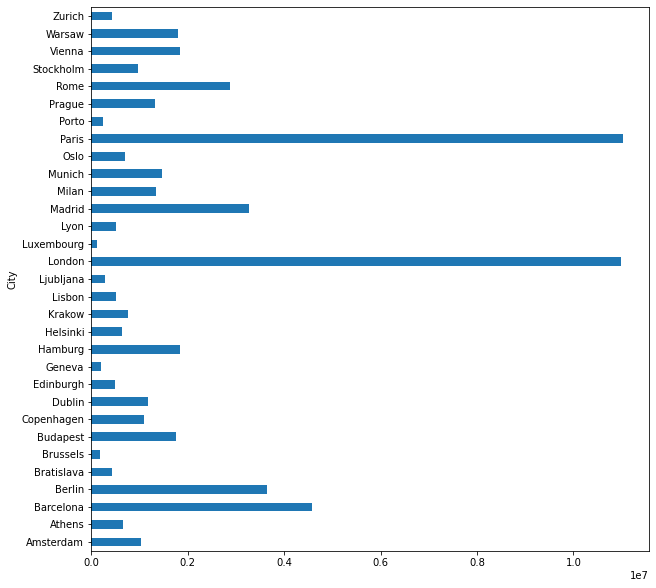

In [25]:
data.groupby('City')['Population'].mean().plot(kind='barh')

In [26]:
# Согласно описанию датасета "worldcities.csv" в "Population" используется муниципальное население
# Что, в целом, должно коррелировать с городским населением

# Нормализуем значения
# т.к. города повторяются, чтобы не вносить погрешность в среднее значение сгруппируем
population = pd.DataFrame(data.groupby('City')['Population'].mean())

scaler=StandardScaler()
population['population_norm'] = scaler.fit_transform(population)

population = population.drop('Population', axis=1)
data = data.merge(population, on='City', how='left')

#data.info()

In [27]:
# scaler=MinMaxScaler()
# data['population_norm'] = scaler.fit_transform(pd.DataFrame(data['Population']))

In [28]:
# Подсчитаем количество ресторанов в каждом городе (входящих в датасет)
data['restaurant_per_city'] = data['City'].map(data.groupby(['City'])['Restaurant_id'].count().to_dict())

scaler=MinMaxScaler()
data['restaurant_per_city_norm'] = scaler.fit_transform(pd.DataFrame(data['restaurant_per_city']))

# Подсчитаем "плотность" ресторанов в городе
# Т.е. подсчитаем количество ресторанов на душу населения в каждом городе
data['restaurant_per_capita'] = data['restaurant_per_city']/data['Population']

---
#### New data 2

In [29]:
tourism_top100 = pd.read_excel('wpTop100Cities19.xlsx', header=None, skiprows=2)

# 1 если входит в топ-100 туристических городов (по данным за 2017-2019 года), 0 если нет
data['tourism_top100'] = data['City'].apply(lambda x: 1 if x in list(tourism_top100[1]) else 0)

# Ranking

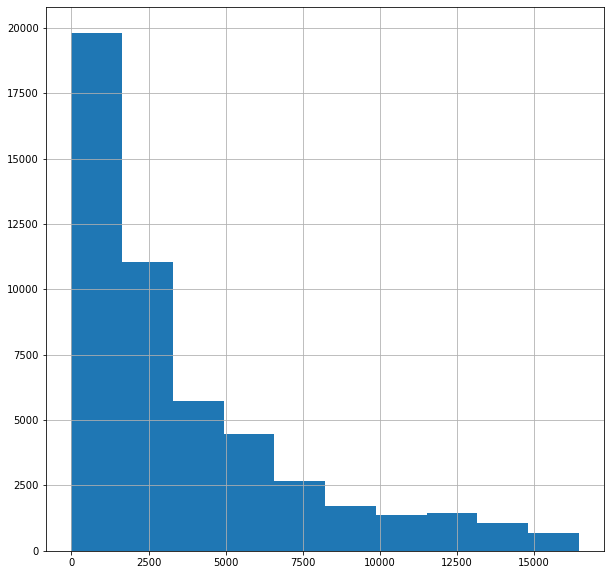

In [30]:
data['Ranking'].hist()

In [31]:
# Так как реальное количество ресторанов явно больше чем представлено в датасете,
# Посчитаем "относительное место", которое занимает ресторан среди "всех" ресторанов своего города
data['relative_ranking'] = data['restaurant_per_city']/data['Ranking']

# scaler=MinMaxScaler()
scaler=StandardScaler()
data['ranking_norm'] = scaler.fit_transform(pd.DataFrame(data['Ranking']))

# Cuisine Style

In [32]:
# Заполним пропуски и очистим строки
data['Cuisine Style'].fillna('other', inplace=True)
data['Cuisine Style'] = data['Cuisine Style'].apply(lambda x: re.sub("[\]'\[]", '', x))

# Подсчитаем количество предлагаемых видов кухонь в ресторане
# Пропуск (other) считаем за один вид
data['cuisines_count'] = data['Cuisine Style'].str.count(',')+1

# data['cuisines_count-ranking'] = data['cuisines_count']/data['Ranking']

# data['cuisines_count-restaurant_per_city'] = data['cuisines_count']/data['restaurant_per_city']

# scaler=StandardScaler()
# # scaler=MinMaxScaler()
# data['cuisines_count_norm'] = scaler.fit_transform(pd.DataFrame(data['cuisines_count']))

# data.head()

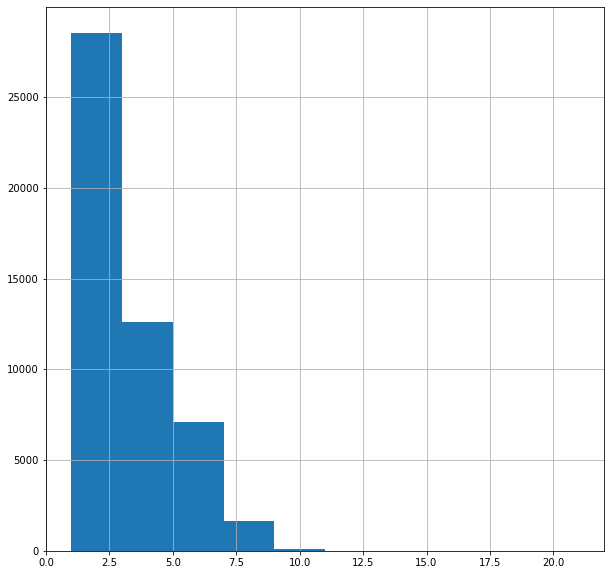

In [33]:
data['cuisines_count'].hist()

In [34]:
get_outlier_iqr(data, 'cuisines_count')

25-й перцентиль: 1.0,  75-й перцентиль: 4.0,  IQR: 3.0,  Границы выбросов: [-3.5<->8.5]

Значения которые являются выбросами:  [9, 10, 11, 13, 15, 21]


In [35]:
len(data[data['cuisines_count'] >= 9])

126

In [36]:
list(data[data['cuisines_count'] == data['cuisines_count'].max()]['Cuisine Style'])

['Asian, Italian, French, American, Indian, Dutch, Bar, Seafood, Fast Food, Mediterranean, Sushi, European, Spanish, Korean, Turkish, Grill, Vietnamese, Street Food, Vegetarian Friendly, Vegan Options, Gluten Free Options']

In [37]:
cuisines = pd.DataFrame(data['Cuisine Style'].str.split(', ', expand = False).explode().reset_index())

cuisines['city'] = data['City'].copy()

data['cuisines_per_city'] = data['City'].map(cuisines.groupby('city')['Cuisine Style'].nunique().to_dict())
data['relative_cuisines_count'] = data['cuisines_count']/data['cuisines_per_city']

# Сократить количество вариантов Cuisine Style
most_popular_cuisines = ['National']
for i in range(0,30):
    most_popular_cuisines.append(Counter(cuisines['Cuisine Style']).most_common(30)[i][0])

cuisines['Cuisine Style'] = cuisines['Cuisine Style'].apply(lambda x: 'National' if x not in most_popular_cuisines else x)

# Создадим Dummy-переменные
for cuisine in most_popular_cuisines:
    id_list = list(cuisines[cuisines['Cuisine Style']==cuisine]['index'])
    data[cuisine] = pd.DataFrame(data.index.map(lambda x: 1 if x in id_list else 0))

# !!! работает очень медленно - спросить на семинаре про альтернативный вариант

# Price Range

In [38]:
price_dict = {'$':0, '$$ - $$$': 1, '$$$$': 2}
data['Price Range'] = data['Price Range'].map(price_dict)
data.head()

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,sample,Rating,chain_size,chain,ranking-chain_size,city_id,Country,Capital,Population,country_id,population_norm,restaurant_per_city,restaurant_per_city_norm,restaurant_per_capita,tourism_top100,relative_ranking,ranking_norm,cuisines_count,cuisines_per_city,relative_cuisines_count,National,Vegetarian Friendly,European,other,Mediterranean,Italian,Vegan Options,Gluten Free Options,Bar,French,Asian,Pizza,Spanish,Pub,Cafe,Fast Food,British,International,Seafood,Japanese,Central European,American,Sushi,Chinese,Portuguese,Indian,Middle Eastern,Thai,Wine Bar,German,Halal
0,id_0,Paris,"Bar, Pub",12963.0,1.0,4.0,"[[], []]",0,0.0,16,0,810.187500,23,France,0,11020000.0,5,3.490592,6108,0.844355,0.000554,1,0.471187,2.513090,2,100,0.020000,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,id_1,Helsinki,"European, Scandinavian, Gluten Free Options, V...",106.0,1.0,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",0,0.0,10,0,10.600000,12,Finland,0,642045.0,4,-0.471331,475,0.036293,0.000740,0,4.481132,-0.961723,5,60,0.083333,1,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,id_2,Edinburgh,Vegetarian Friendly,810.0,1.0,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",0,0.0,15,0,54.000000,9,United Kingdom,0,488050.0,21,-0.530120,745,0.075025,0.001526,0,0.919753,-0.771455,1,76,0.013158,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,id_3,London,"Italian, Mediterranean, European, Vegetarian F...",1669.0,2.0,202.0,"[['Most exquisite', 'Delicious and authentic']...",0,0.0,9,0,185.444444,16,United Kingdom,0,10979000.0,21,3.474940,7193,1.000000,0.000655,1,4.309766,-0.539297,5,109,0.045872,0,1,1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,id_4,Bratislava,"Italian, Mediterranean, European, Seafood, Veg...",37.0,2.0,162.0,"[['Always the best in bratislava', 'Very good ...",0,0.0,14,0,2.642857,4,Slovakia,0,429564.0,16,-0.552448,380,0.022665,0.000885,0,10.270270,-0.980371,6,59,0.101695,0,1,1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [39]:
# Предположим, что цены в одной сети ресторанов +- одинаковые
# Заполним пропуски медианным значением для каждой сети ресторанов
data['Price Range'].fillna(data['Restaurant_id'].\
                           map(data.groupby(['Restaurant_id'])['Price Range'].median().to_dict()),\
                           inplace=True)

In [40]:
# Оставшиеся пропуски заполним медианным значением по каждому городу
data['Price Range'].fillna(data['City'].\
                           map(data.groupby(['City'])['Price Range'].median().to_dict()),\
                           inplace=True)

In [41]:
data['relative_price'] = data['Price Range']/data['relative_ranking']

# Reviews

In [42]:
data[data['Reviews'].isna()]

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,sample,Rating,chain_size,chain,ranking-chain_size,city_id,Country,Capital,Population,country_id,population_norm,restaurant_per_city,restaurant_per_city_norm,restaurant_per_capita,tourism_top100,relative_ranking,ranking_norm,cuisines_count,cuisines_per_city,relative_cuisines_count,National,Vegetarian Friendly,European,other,Mediterranean,Italian,Vegan Options,Gluten Free Options,Bar,French,Asian,Pizza,Spanish,Pub,Cafe,Fast Food,British,International,Seafood,Japanese,Central European,American,Sushi,Chinese,Portuguese,Indian,Middle Eastern,Thai,Wine Bar,German,Halal,relative_price
8168,id_8168,Lisbon,other,3389.0,1.0,2.0,NaN,0,0.0,2,0,1694.5,14,Portugal,0,506654.0,15,-0.523018,1647,0.204418,0.003251,1,0.485984,-0.074439,1,82,0.012195,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.057681
9608,id_9608,Vienna,other,1779.0,1.0,NaN,NaN,0,0.0,1,1,1779.0,28,Austria,0,1840573.0,0,-0.013777,1443,0.175154,0.000784,1,0.811130,-0.509567,1,79,0.012658,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.232848


In [43]:
# Заполним пропуски
data['Reviews'].fillna('nothing', inplace = True)

In [44]:
# Вытащим даты публикации Reviews
data['reviews_date'] = data['Reviews'].apply(lambda x: pd.to_datetime(re.findall('\d{2}/\d{2}/\d{4}', x)))

In [45]:
data['last_review_date'] = data['reviews_date'].apply(lambda x: max(x) if len(x)!=0 else None)
data['next2last_review_date'] = data['reviews_date'].apply(lambda x: min(x) if len(x)>1 else None)

In [46]:
# Посчитаем промежуток времени между Reviews
data['reviews_date_delta'] = (data['last_review_date'] - data['next2last_review_date']).dt.days
# Заполним пропуски
data['reviews_date_delta'].fillna(0, inplace = True)

In [47]:
# Посчитаем сколько времени прошло с момента написания последнего Review
data['last_review_age'] = (datetime.strptime('2021/01/17', '%Y/%m/%d') - data['last_review_date']).dt.days
# Заполним пропуски
data['last_review_age'].fillna(0, inplace = True)

In [48]:
# data['Reviews'] = data['Reviews'].apply(lambda x: re.findall("[a-zA-Z]+\D+[a-zA-Z]+", x))

# Number of Reviews

In [49]:
# Создаем временный столбец. 1 если есть хоть один отзыв и 0 если нет ни одного
data['no_reviews'] = data['last_review_date'].apply(lambda x: 1 if pd.isna(x) == False else 0)
# Заполняем пропуски
data['Number of Reviews'].fillna(1, inplace=True)
# Исправляем ранее присвоению единицу на 0 если отзывов нет
data['Number of Reviews'] = data['Number of Reviews'] * data['no_reviews']

data = data.drop(['no_reviews'], axis=1)

In [50]:
data['review_per_day'] = data['reviews_date_delta'].apply(lambda x: 1/x if x > 0 else x)

In [51]:
# Как часто в городе оставляют отзывы
data['review_per_capita'] = data['Number of Reviews'] / data['Population']

In [52]:
data['cuisines_count-num_rev'] = data['cuisines_count']/data['Number of Reviews']

In [53]:
# Ранг ресторана с учетом частоты отзывов в городе
data['WRR'] =  data['relative_ranking']  *  data['review_per_capita']

In [54]:
# Так как snapshot "старый" нормализует last_review_age
scaler=MinMaxScaler()
# scaler=StandardScaler()
data['last_review_age_norm'] = scaler.fit_transform(pd.DataFrame(data['last_review_age']))

In [55]:
# посмотреть что получится
scaler=MinMaxScaler()
# scaler=StandardScaler()
data['reviews_date_delta_norm'] = scaler.fit_transform(pd.DataFrame(data['reviews_date_delta']))

In [56]:
# опять же посмотреть что получится
data['restaurant_age_onTA'] = pd.DataFrame(map(lambda x, y: x/y if y > 0 else 0,
                                               data['Number of Reviews'],
                                               data['review_per_day']))

In [57]:
# так же
scaler=MinMaxScaler()
# scaler=StandardScaler()
data['restaurant_age_onTA_norm'] = scaler.fit_transform(pd.DataFrame(data['restaurant_age_onTA']))

# Review distribution

In [58]:
data_upd = pd.read_csv('main_task_update.csv')
data_upd = data_upd[['nr_reviews', 'excellent', 'v_good', 'average', 'poor', 'terrible']]

In [59]:
data = data.merge(data_upd, left_index=True, right_index = True)

In [60]:
data['excellent_perc'] = pd.DataFrame(map(lambda x, y: x/y if y>0 else 0,
                                          data['excellent'], data['nr_reviews']))

data['v_good_perc'] = pd.DataFrame(map(lambda x, y: x/y if y>0 else 0,
                                       data['v_good'], data['nr_reviews']))

data['average_perc'] = pd.DataFrame(map(lambda x, y: x/y if y>0 else 0,
                                        data['average'], data['nr_reviews']))

data['poor_perc'] = pd.DataFrame(map(lambda x, y: x/y if y>0 else 0,
                                     data['poor'], data['nr_reviews']))

data['terrible_perc'] = pd.DataFrame(map(lambda x, y: x/y if y>0 else 0,
                                         data['terrible'], data['nr_reviews']))

# Dropping of columns

In [61]:
cuisine_dummies = list(cuisines['Cuisine Style'].unique())

In [62]:
drop_list = ['Restaurant_id',
             'Rating',
             'Country',
             'City',
             'Cuisine Style',
             'Reviews',
             'reviews_date',
             'last_review_date',
             'next2last_review_date',
             'chain_size',
#              'cuisines_count',
#              'cuisines_count_norm',
#              'Population',
#              'population_norm',
#              'Ranking',
#              'relative_ranking',
#              'Number of Reviews',
#              'restaurant_per_city',
#              'reviews_date_delta',
#              'last_review_age',
#              'restaurant_age_onTA',
#              'excellent',
#              'v_good',
#              'average',
#              'poor',
#              'terrible'
            ]

corr_list = []
for i in list(data.columns):
    if i not in cuisine_dummies and i not in drop_list:
        corr_list.append(i)

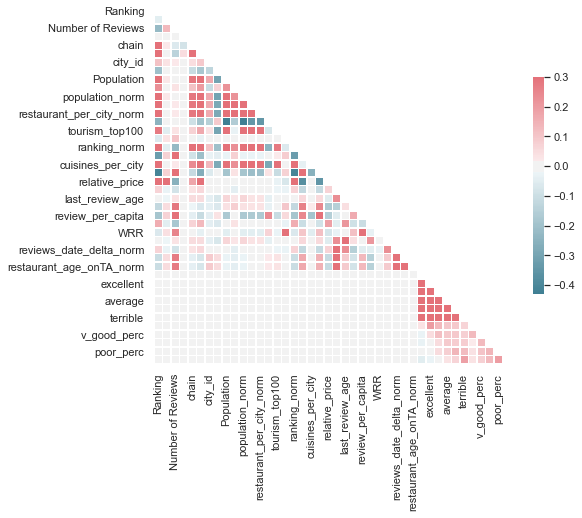

In [63]:
sns.set(style="white")
corr = data[corr_list].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 8))

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [64]:
data = data.drop(drop_list, axis=1)
data.head()

,Ranking,Price Range,Number of Reviews,sample,chain,ranking-chain_size,city_id,Capital,Population,country_id,population_norm,restaurant_per_city,restaurant_per_city_norm,restaurant_per_capita,tourism_top100,relative_ranking,ranking_norm,cuisines_count,cuisines_per_city,relative_cuisines_count,National,Vegetarian Friendly,European,other,Mediterranean,Italian,Vegan Options,Gluten Free Options,Bar,French,Asian,Pizza,Spanish,Pub,Cafe,Fast Food,British,International,Seafood,Japanese,Central European,American,Sushi,Chinese,Portuguese,Indian,Middle Eastern,Thai,Wine Bar,German,Halal,relative_price,reviews_date_delta,last_review_age,review_per_day,review_per_capita,cuisines_count-num_rev,WRR,last_review_age_norm,reviews_date_delta_norm,restaurant_age_onTA,restaurant_age_onTA_norm,nr_reviews,excellent,v_good,average,poor,terrible,excellent_perc,v_good_perc,average_perc,poor_perc,terrible_perc
0,12963.0,1.0,0.0,0,0,810.187500,23,0,11020000.0,5,3.490592,6108,0.844355,0.000554,1,0.471187,2.513090,2,100,0.020000,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.122299,0.0,0.0,0.000000,0.000000,inf,0.000000,0.000000,0.000000,0.0,0.000000,227,19,42,20,14,6,0.083700,0.185022,0.088106,0.061674,0.026432
1,106.0,1.0,97.0,0,0,10.600000,12,0,642045.0,4,-0.471331,475,0.036293,0.000740,0,4.481132,-0.961723,5,60,0.083333,1,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.223158,37.0,1139.0,0.027027,0.000151,0.051546,0.000677,0.186263,0.011226,3589.0,0.003215,15,2,1,1,0,0,0.133333,0.066667,0.066667,0.000000,0.000000
2,810.0,1.0,28.0,0,0,54.000000,9,0,488050.0,21,-0.530120,745,0.075025,0.001526,0,0.919753,-0.771455,1,76,0.013158,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.087248,22.0,1116.0,0.045455,0.000057,0.035714,0.000053,0.182502,0.006675,616.0,0.000552,992,485,198,82,35,29,0.488911,0.199597,0.082661,0.035282,0.029234
3,1669.0,2.0,202.0,0,0,185.444444,16,0,10979000.0,21,3.474940,7193,1.000000,0.000655,1,4.309766,-0.539297,5,109,0.045872,0,1,1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.464062,14.0,1138.0,0.071429,0.000018,0.024752,0.000079,0.186100,0.004248,2828.0,0.002533,3,3,0,0,0,0,1.000000,0.000000,0.000000,0.000000,0.000000
4,37.0,2.0,162.0,0,0,2.642857,4,0,429564.0,16,-0.552448,380,0.022665,0.000885,0,10.270270,-0.980371,6,59,0.101695,0,1,1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.194737,15.0,1074.0,0.066667,0.000377,0.037037,0.003873,0.175634,0.004551,2430.0,0.002177,178,6,13,3,1,0,0.033708,0.073034,0.016854,0.005618,0.000000
